As it is (without anything downloaded and always with 1 epoch when needed), the running time of the whole notebook is (approximately) <span style="background-color: lightblue"> 4 minutes</span>.

<span style="background-color: yellow"> </span>

#### Libraries

In [59]:
########################## UTILITY AND SYSTEM ##########################

import os                       # filesystem operations
import csv                      # reading/writing CSV files
import json                     # JSON parsing and serialization
import math                     # basic math functions
import random                   # random number generation
import time                     # time-related functions
import tempfile                 # temporary file management
import tarfile                  # tar archive handling
import io                       # input/output streams
import pickle                   # object serialization
import importlib                # dynamic import of modules
import multiprocessing          # parallel process management
import pkg_resources            # package and dependency management
from copy import deepcopy       # deep copy of objects
from pathlib import Path        # filesystem paths handling (cross-platform)

########################## DOWNLOAD ##########################

import requests                 # HTTP requests library
import wget                     # file downloads from URLs
from urllib.request import urlopen  # open URLs (alternative to requests)

########################## VISUALIZATION ##########################

import matplotlib.pyplot as plt # basic plotting library
import plotly.graph_objs as go  # interactive plotting
from tqdm.notebook import tqdm  # progress bars for loops in notebooks
from pprint import pprint       # formatted pretty-printing of objects

########################## DATAFRAME ##########################

import numpy as np              # numerical arrays and operations
import pandas as pd             # dataframes and data manipulation
from sklearn.manifold import TSNE

########################## TEXT PROCESSING ##########################

import re                      # regular expressions
import string                  # string constants and operations
from itertools import chain, islice  # advanced iteration and chaining

########################## TOKENIZATION ##########################

from collections import Counter, OrderedDict  # frequency counts and ordered dictionaries
import nltk                                   # natural language processing toolkit
from nltk.tokenize import word_tokenize       # word tokenization
import spacy                                  # advanced NLP (tokenization, parsing)
from torchtext.data.utils import get_tokenizer       # torchtext tokenizers
from torchtext.data.functional import to_map_style_dataset

from torchtext.vocab import build_vocab_from_iterator # build vocabulary from iterator

########################## DATASET AND DATALOADER ##########################

from torch.utils.data import Dataset, DataLoader, random_split   # datasets and data loading utilities
from torch.nn.utils.rnn import pad_sequence                      # padding variable-length sequences
from datasets import load_dataset, DatasetDict                   # HuggingFace datasets loading
from torchtext.datasets import AG_NEWS                           # torchtext built-in datasets

########################## PYTORCH AND DEEP LEARNING ##########################

import torch                             # PyTorch main library
from torch import nn, Tensor             # neural network modules and tensors
from torch.nn import CrossEntropyLoss    # common loss function for classification
from torchsummary import summary as torchsummary
from torchinfo import summary as torchinfosummary

########################## WORD EMBEDDING ##########################

from torchtext.vocab import GloVe        # pretrained GloVe embeddings
# from gensim.models import Word2Vec     # word2vec embeddings from corpus (commented out)

########################## HUGGING FACE ##########################

import transformers                      # transformers library core
from transformers import (
    GPT2Tokenizer, GPT2LMHeadModel,     # GPT-2 tokenizer and model
    BertTokenizer, BertTokenizerFast, BertConfig, BertForMaskedLM,  # BERT components
    XLNetTokenizer,                     # XLNet tokenizer
    DistilBertForSequenceClassification, DistilBertTokenizer, AutoModelForSequenceClassification,
    pipeline,                          # easy pipelines for inference
    AutoTokenizer,                    # auto tokenizer loader
    AutoModelForCausalLM, GPT2ForSequenceClassification,
    DataCollatorForLanguageModeling, TrainingArguments, Trainer,  # training utilities
    set_seed, GenerationConfig,
    BertModel,                        # BERT base model
    PreTrainedTokenizerBase
)
from datasets import DatasetDict         # HuggingFace dataset dictionaries

######################### TRL & PEFT (TRAINING & PARAMETER EFFICIENT FINE-TUNING) ##########################

from trl import (
    SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM,
    DPOConfig, DPOTrainer,
    RewardTrainer, RewardConfig
)
from peft import get_peft_model, LoraConfig, TaskType
from torchmetrics import Accuracy        # metrics for evaluation

########################## RAG ##########################

from transformers import (
    DPRQuestionEncoder, DPRQuestionEncoderTokenizer,
    DPRContextEncoder, DPRContextEncoderTokenizer
)
import faiss                              # similarity search library

########################## EVALUATION ##########################

import evaluate



In [60]:
def accelerator(where = "mps"):
    if where == "mps":
        device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
        print("Which device we are on: {}".format(device))
        return device
    if where == "cuda":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("Which device we are on: {}".format(device))
        return device
    if where == "cpu":
        device = torch.device("cpu")
        print("Which device we are on: {}".format(device))
        return device

device = accelerator("cpu")

Which device we are on: cpu


# A) CONCEPTS: Instruction-Tuning, Reward modelling, PPO, DPO

## Fine-Tuning vs Alignement-tuning

Fine-tuning LLMs adapts pre-trained models to specif tasks/domains using domain-specific data. This process adjust model's parameters to improve task performance, and is useful if you have a limited dataset. Moreover it is time and resources efficient. We should pay attention to **catastrophic forgetting**, to prevent the model from losing its initial broad knowledge. Two main approaches to optimize language models:
1. <span style="background-color: yellow">FINE-TUNING</span>: improve the general features of a model on a specific task, or <span style="background-color: pink">"learn the task"</span>. This can be done in various ways:
    1. Self-supervised fine-tuning;
    2. SFT supervised fine-tuning:
        - Full fine-tuning;
        - PEFT Parameter-efficient fine-tuning (<span style="background-color: orange">adapters and LoRA</span>);
2. <span style="background-color: yellow">ALIGNEMENT-TUNING</span>: improve the behaviour and alignement of a model on the human preferences, or <span style="background-color: pink">"become similar to humans"</span>. This is done with:
    - Instruction-tuning, which is supervised, and then (one or the other):
        1. RHLF: reinforcement learning from human feedback, or reward-modelling;
        2. DPO: direct preference optimization, which does not need rewards and is directly controlled by humans.

| Aspect                         | <span style="background-color: yellow">FINE-TUNING</span>              | <span style="background-color: yellow">ALIGNEMENT-TUNING</span>  |
|-------------------------------|--------------------------------------------------|---------------------------------------------------|
| **Main Goal**                 | Task-specific skill improvement                  | Align model behavior with human intent            |
| **Data Format**              | Input → Target (e.g., text → label or answer)    | Instruction + Response, Human Preference pairs    |
| **Supervision Type**         | Supervised or semi-supervised                    | Supervised (instructions), Reinforcement (RLHF), or Preference Optimization (DPO) |
| **Use Case**                 | Classification, summarization, translation, etc. | Chatbots, assistants, safe and helpful responses  |
| **Model Focus**              | Learning the correct output                      | Learning *how to behave* appropriately            |
| **Parameter Updates**        | Full model (or partial via PEFT)                 | Usually full model tuning in multiple stages      |
| **Typical Final Goal**       | Accuracy, F1, BLEU, etc.                         | Helpfulness, safety, alignment with human values  |

## Alignement-Tuning

### Instruction-Tuning

It trains the model with <span style="background-color: yellow">expert labeled dataset </span> and is used before DPO (direct preference optimization) and RLHF (Reinf Learning from human feedback). It is composed by:
1. **instruction** (es: answer the following question based on the provided context)
2. **input** (es: What is the most important achievement of Einstein? He was a physicist.) **Not all models have input**
3. **output** (es: He is best known for E=mc^2.)



Usually, we use **Instruction masking**:

During training, instruction tokens are masked (ignored in loss calculation), while response tokens are unmasked (used to compute loss).
This ensures the model focuses on learning how to generate accurate answers rather than memorizing question formats.

Why?

Prevents overfitting to the instruction phrasing

Improves response generation quality

The temperature parameter in language models controls how random or predictable the generated responses are. Here's a simple breakdown:

Low Temperature (e.g., 0.5): The model becomes more conservative. It tends to choose words that are more likely based on the context, leading to more predictable and coherent responses. Think of it as a chef sticking to a traditional recipe.
High Temperature (e.g., 2.0 or higher): The model becomes more adventurous. It allows for a wider range of word choices, including less likely options, resulting in more diverse and creative responses. This is like a chef experimenting with unusual ingredients.

Example: 

At a low temperature, if the prompt is "The sky is," the model might generate "blue" or "clear."
At a high temperature, it might generate "purple" or "filled with marshmallows," leading to more unexpected and imaginative responses.


#### examples of templates

Let's review certain examples for various templates:

---
#### Response template
Template: `### Question: {question}\n ### Answer: {answer}`

Example:
```
### Question: What is the capital of France?
### Answer: Paris
```

---
#### Conversation template

Template: `### User: {user_input}\n ### Bot: {bot_response}`
Example:
```
### User: How are you today?
### Bot: I'm doing great, thank you! How can I assist you today?
```

---
#### Instruction and output template

Template: `### Instruction: {instruction}\n ### Output: {output}`

Example:
```
### Instruction: Translate the following sentence to Spanish: "Hello, how are you?"
### Output: "Hola, ¿cómo estás?"
```

---
#### Completion template

Template: `{prompt} ### Completion: {completion}`
Example:
```
Once upon a time in a faraway land, ### Completion: there lived a wise old owl who knew all the secrets of the forest.
```

#### Summarization template

Template: `### Text: {text}\n ### Summary: {summary}`

Example:
```
### Text: The quick brown fox jumps over the lazy dog.
### Summary: A fox jumps over a dog.
```

---
#### Dialogue template

Template: `### Speaker 1: {utterance_1}\n ### Speaker 2: {utterance_2}\n ### Speaker 1: {utterance_3}`

Example:
```
### Speaker 1: Hi, what are you doing today?
### Speaker 2: I'm going to the park.
### Speaker 1: That sounds fun!
```

---
#### Code generation template

Template: `### Task: {task_description}\n ### Code: {code_output}`

Example:
```
### Task: Write a function to add two numbers in Python.
### Code: def add(a, b):\n    return a + b
```

---
#### Data analysis template

Template: `### Analysis Task: {task_description}\n ### Analysis: {analysis_output}`

Example:
```
### Analysis Task: Provide insights from the sales data of Q1 2022.
### Analysis: The sales increased by 15% compared to Q4 2021, with the highest growth in the electronics category.
```

---
#### Recipe template

Template: `### Recipe Name: {recipe_name}\n ### Ingredients: {ingredients}\n ### Instructions: {instructions}`

Example:
```
### Recipe Name: Chocolate Chip Cookies
### Ingredients: Flour, Sugar, Chocolate Chips, Butter, Eggs, Vanilla Extract
### Instructions: Mix the dry ingredients, add the wet ingredients, fold in the chocolate chips, and bake at 350°F for 10-12 minutes.
```

---
#### Explanation template

Template: `### Concept: {concept}\n ### Explanation: {explanation}`

Example:
```
### Concept: Photosynthesis
### Explanation: Photosynthesis is the process by which green plants use sunlight to synthesize nutrients from carbon dioxide and water.
```

---


### RLHF: Reward modelling (Response Evaluation)

Quantify response quality by assigning numerical values to responses to assess and compare performances. Moreover it reflects user preferences for customized model behaviour:

- The dataset used in this case, as said in 'instruction-tuning' is an <span style="background-color: yellow">expert labeled dataset </span>. In particular, given a model, it comprises:
    - a question;
    - one or more answers predicted by the model;
    - a label, given by an human, which choose the preferable answer.

For example

| Prompt                                                | Response A                                           | Response B                                           | Preferred |
|-------------------------------------------------------|------------------------------------------------------|------------------------------------------------------|-----------|
| What is the capital of France?                        | The capital of France is Paris.                      | France is a country in Europe.                       | A         |
| Can you explain the theory of evolution in simple terms? | Evolution is the idea that species change over time through natural selection. | Charles Darwin was a British naturalist born in 1809. | A         |




 We tokenize the query (with tokens $\text{word}_{i}$) and the answer (with tokens $\widehat{\text{word}}_{i}$, where the hat is present because this is generated by the model, so it is an extimation). Then we use the function $r$ on 

$$ r(\text{word}_1,\ldots,\text{word}_{N_{\text{query}}},\widehat{\text{word}}_1,\ldots,\widehat{\text{word}}_{N_{\text{answer}}})\,.$$

This function $r$ is obtained with a trainable model with an appropriate loss. So we want to train a model that identifies the desidered model from another model, basing on context and preferences.
1. **function $r$**: it is the contextual embedding from an encoder of the concatenated $\text{word}_1,\ldots,\text{word}_{N_{\text{query}}},\widehat{\text{word}}_1,\ldots,\widehat{\text{word}}_{N_{\text{answer}}}$. This embedding is then projected (e.g., via a linear layer) to a scalar reward score.
2. **Bradley-Terry reward loss** is used: using two different responses $A$ and $B$, find the parameters by applying 

$$ \argmin_{\text{parameters}} \bigl[-\sigma(r_A - r_B) \bigr]\,.$$  
This encourages the model to assign a higher score to the preferred response.

Given a reward function $r$, the expected reward for N queries, each with K possible answers, is

$$ E[r]\sim \frac{1}{N}\sum_{n}^{N} \frac{1}{K} \sum_{k}^{K} r(\text{query}_n, \text{answer}_{n,k})$$

### Proximal Policy Optimization (PPO)

The idea is to use reinforcement learning (from human feedback) like this:
1. We have a LLM model $M_L$ (that needs to be fine-tuned by instruction fine-tuning), a reference model $M$ (pre-trained) and a reward model $M_R$;
2. Give a $\text{query}_n$ to $M_L$, this produces $K$ answers $\text{answer}_{n,k}$;
3. The model $M_R$ computes the rewards $r(\text{query}_n, \text{answer}_{n,k})$;
4. Maximize a target function, which is the PPO (Proximal Policy Optimization) objective:
   - a) Compute the log-probabilities of the generated answers under the current and reference (pre-trained) models;
   - b) Use the reward signal $r$ to calculate the advantage estimates (e.g., via Generalized Advantage Estimation - GAE);
   - c) Optimize the PPO clipped objective to update $M_L$, encouraging responses with higher rewards while staying close to the reference model;
   - d) Optionally apply KL penalties to prevent the model from drifting too far from the original distribution;
   - e) Repeat this process across multiple queries, batches, and epochs until convergence or performance stabilizes.

### Direct Preference Optimization (DPO)

Differently from the indirect $r$ method, DPO (which is a RL tecnique) directly change parameters to produce output aligned with human's feedback. In practice, the User should choose among two outputs. The optimal solution is to minimze the KL divergence, which brings to

$$
\mathcal{L}_{\text{DPO}} = -\log\bigg[ \frac{\exp(\beta \cdot \log \pi_\theta(y^+|x))}{\exp(\beta \cdot \log \pi_\theta(y^+|x)) + \exp(\beta \cdot \log \pi_\theta(y^-|x))} \bigg]\,.
$$


# 1) Instruction-Tuning

## Dataset

We use the CodeAlpaca 20k dataset (a coding dataset), and to keep thing simple we discard the examples that contain any 'input'

In [61]:
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/WzOT_CwDALWedTtXjwH7bA/CodeAlpaca-20k.json

dataset = load_dataset("json", data_files = "CodeAlpaca-20k.json", split = "train") #this *does not* take only the train subset
dataset = dataset.filter(lambda example: example["input"] == '')

dataset = dataset.shuffle(seed=42) #shuffle it to be sure

dataset_split = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = dataset_split['train']
test_dataset = dataset_split['test']

tiny_train_dataset = train_dataset.select(range(10))
tiny_test_dataset = test_dataset.select(range(10))

python(19888) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


--2025-08-03 16:21:22--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/WzOT_CwDALWedTtXjwH7bA/CodeAlpaca-20k.json
Risoluzione di cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connessione a cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 200 OK
Lunghezza: 6957007 (6.6M) [application/json]
Salvataggio in: «CodeAlpaca-20k.json»

CodeAlpaca-20k.json 100%[===================>]   6.63M  3.42MB/s    in 1.9s    

2025-08-03 16:21:25 (3.42 MB/s) - «CodeAlpaca-20k.json» salvato [6957007/6957007]



In [62]:
tiny_train_dataset[7]

{'output': 'for i in list_str:\n  print(i.upper())',
 'instruction': 'Given the following list of strings:\n\nlist_str  = ["one", "two", "three", "four", "five"]\n\nWrite a program that prints out the strings in uppercase.',
 'input': ''}

## Model to be fine-tuned on the dataset

We load the model and its own toeknizer. This is not fine-tuned for prompt structured as "### Instruction:" and "### Response:". We will have to take this into account later, in the pre-processing section

In [63]:
model = AutoModelForCausalLM.from_pretrained("facebook/opt-350m").to(device)
tokenizer = AutoTokenizer.from_pretrained("facebook/opt-350m", padding_side = 'left')

## Pre-processing of the dataset

It is necessary now to put the dataset in a suitable format. The suitable format, in this case, is
```
'### Instruction:\nConstruct an array of size 10 to store integers in Java.\n\n### Response:\nint[] array = new int[10];</s>'
```
Here `</s>` is the end toke, available as `tokenizer.eos_token`.

In particular we need to generate two functions, one with instructions and responses, and one with the instructions only for the training

In [64]:
def formatting_prompts_func(dataset):
    output_texts = []
    for i in range(len(dataset['instruction'])):
        text = (
            f"### Instruction:\n{dataset['instruction'][i]}"
            f"\n\n### Response:\n{dataset['output'][i]}</s>"
        )
        output_texts.append(text)
    return output_texts

def formatting_prompts_func_no_response(dataset):
    output_texts = []
    for i in range(len(dataset['instruction'])):
        text = f"### Instruction:\n{dataset['instruction'][i]}"
        output_texts.append(text)
    return output_texts

Example of usage:

In [65]:
print(formatting_prompts_func(tiny_test_dataset)[2])

### Instruction:
How do you remove the last item from a list in Python?

### Response:
list.pop()</s>


On the test dataset, we have to create some lists

| List                         | Content                                                           | Purpose                                                                 |
|-----------------------------|--------------------------------------------------------------------|-------------------------------------------------------------------------|
| `instructions_with_responses` | Full prompt: **instruction + expected response + `</s>` token**     | Create `expected_outputs`                  |
| `instructions`                | Only **instruction**, without response                             | Used as input to test the model (to generate the response)              |
| `expected_outputs`            | Only **expected response**, extracted from `instructions_with_responses`, without `</s>`  | Used to compare with generated output and compute metrics (e.g., BLEU) |


Moreover, we could not have created them before (in particular the outputs) because:

| Aspect                | `dataset["output"]`                            | `expected_outputs`                                                  |
|-----------------------|------------------------------------------------|----------------------------------------------------------------------|
| Source                | Directly from the original dataset             | Extracted from tokenized prompt and response                        |
| Includes `</s>`       | May include `</s>` if present in the dataset   | Explicitly removes `</s>` during processing                         |
| Based on tokenization | ❌ Not tokenized                               | ✅ Tokenized and decoded from model input                            |
| Used for BLEU/metrics | ❌ Not reliable for precise metrics            | ✅ Used for exact match and evaluation (e.g., BLEU, SacreBLEU)       |
| Alignment with model  | Might not match token-level model outputs      | Precisely aligned with model-generated tokens                       |
| Purpose               | For general inspection or display              | For rigorous evaluation of model's response                         |


In [66]:
# it takes 36s

expected_outputs = []
instructions_with_responses = formatting_prompts_func(test_dataset)
instructions = formatting_prompts_func_no_response(test_dataset)
for i in tqdm(range(len(instructions_with_responses))):
    tokenized_instruction_with_response = tokenizer(instructions_with_responses[i], return_tensors="pt", max_length=1024, truncation=True, padding=False)
    tokenized_instruction = tokenizer(instructions[i], return_tensors="pt", max_length=1024, truncation=True, padding=False)
    expected_output = tokenizer.decode(
    tokenized_instruction_with_response['input_ids'][0][len(tokenized_instruction['input_ids'][0]):],
    skip_special_tokens=True
    )

    expected_outputs.append(expected_output)

  0%|          | 0/1953 [00:00<?, ?it/s]

In [67]:
print('############## "INSTRUCTIONS" LIST: ##############\n' + instructions[2])
print('############## "INSTRUCTIONS_WITH_RESPONSES" LIST ##############\n' + instructions_with_responses[2])
print('\n############## "EXPECTED_OUTPUTS" LIST: ##############' + expected_outputs[2])

############## "INSTRUCTIONS" LIST: ##############
### Instruction:
How do you remove the last item from a list in Python?
############## "INSTRUCTIONS_WITH_RESPONSES" LIST ##############
### Instruction:
How do you remove the last item from a list in Python?

### Response:
list.pop()</s>

############## "EXPECTED_OUTPUTS" LIST: ##############

### Response:
list.pop()


In [68]:
class ListDataset(Dataset):
    def __init__(self, original_list):
        self.original_list = original_list
    
    def __len__(self):
        return len(self.original_list)
    
    def __getitem__(self, i):
        return self.original_list[i]

instructions_torch = ListDataset(instructions)

## Test the model without fine-tuning

In [69]:
gen_pipeline = pipeline("text-generation",
                        model = model,
                        tokenizer = tokenizer,
                        device = device,
                        batch_size = 2,
                        max_length = 50, #this limit the generated tokens for prompt+output (which may not be always right)
                        max_new_tokens = 50, # This limit only the generated tokens
                        return_full_text = False) #if True, the generation pipeline generates both the instructions and the responses
                        # return_tensors = True) #if True, the generation pipeline returns token IDs

In [70]:
# it takes 40s
tokenizer.padding_side = 'left'


with torch.no_grad():
    # Due to resource limitation, only apply the function on 3 records using "instructions_torch[:10]"
    pipeline_iterator= gen_pipeline(instructions[:3], 
                                    max_length = 50, # this is set to 50 due to resource constraint, using a GPU, you can increase it to the length of your choice
                                    num_beams = 5,
                                    early_stopping = True)

generated_outputs_base = []
for i, text in enumerate(pipeline_iterator):
    gen_output = text[0]["generated_text"]
    prompt = instructions[i]
    response_only = gen_output[len(prompt):].strip()
    generated_outputs_base.append(response_only)

Both `max_new_tokens` (=50) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=50) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


In [71]:
for i in range(3):
    print('@@@@@@@@@@@@@@@@@@@@')
    print('@@@@@ Instruction '+ str(i+1) +': ')
    print(instructions[i])
    print('\n\n')
    print('@@@@@ Expected response '+ str(i+1) +': ')
    print(expected_outputs[i])
    print('\n\n')
    print('@@@@@ Generated response '+ str(i+1) +': ')
    print(generated_outputs_base[i])
    print('\n\n')
    print('@@@@@@@@@@@@@@@@@@@@')

@@@@@@@@@@@@@@@@@@@@
@@@@@ Instruction 1: 
### Instruction:
Name the most important benefit of using a database system.



@@@@@ Expected response 1: 


### Response:
The most important benefit of using a database system is the ability to store and retrieve data quickly and easily. Database systems also provide support for data security, data integrity, and concurrently accessing and modifying data from multiple systems.



@@@@@ Generated response 1: 




@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@
@@@@@ Instruction 2: 
### Instruction:
Come up with a Java program that checks if one string is a substring of another.



@@@@@ Expected response 2: 


### Response:
public static boolean isSubstring(String s, String x) {
    int i = 0, j = 0;
    while (i < s.length() && j < x.length()) {
        if (s.charAt(i) == x.charAt(j)) {
            i++;
            j++;
        } else {
            i = i - j + 1;
            j = 0;
        }
    }
    if (j == x.length()) {
        return true;
  

Let's set up a metric that compares the generated responses and the expected responses in the test environment. In this lab, let's use the [BLEU score](https://en.wikipedia.org/wiki/BLEU), a metric originally intended to check the quality of translations made by translation models. You can calculate the BLEU scores for individual generated segments by comparing them with a set of expected outputs and average the scores for the individual segments. Depending on the implementation, BLEU scores range from 0 to 1 or from 0 to 100 (as in the implementation used herein), with higher scores indicating a better match between the model generated output and the expected output.

_**Note:**_ 
1. The BLEU score was originally implemented for assessing the quality of translations. However, it may not necessarily be the best metric for instruction fine-tuning in general, but it is nonetheless a useful metric that gives a sense of the alignment between the model generated output and the expected output.
2. BLEU scores are very challenging to compare from one study to the next because it is a parametrized metric. As a result, you can employ a variant of BLEU called [SacreBLEU](https://aclanthology.org/W18-6319/) invariant to the metric's parametrization.

In [72]:
sacrebleu = evaluate.load("sacrebleu")
results_base = sacrebleu.compute(predictions = generated_outputs_base,
                                 references = expected_outputs[0:3])

print(list(results_base.keys()))
print(round(results_base["score"], 1))

['score', 'counts', 'totals', 'precisions', 'bp', 'sys_len', 'ref_len']
0.0


### Loading complete data (not really needed)

In [73]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/VvQRrSqS1P0_GobqtL-SKA/instruction-tuning-generated-outputs-base.pkl')
generated_outputs_base = pickle.load(io.BytesIO(urlopened.read()))

In [74]:
for i in range(3):
    print('@@@@@@@@@@@@@@@@@@@@')
    print('@@@@@ Instruction '+ str(i+1) +': ')
    print(instructions[i])
    print('\n\n')
    print('@@@@@ Expected response '+ str(i+1) +': ')
    print(expected_outputs[i])
    print('\n\n')
    print('@@@@@ Generated response '+ str(i+1) +': ')
    print(generated_outputs_base[i])
    print('\n\n')
    print('@@@@@@@@@@@@@@@@@@@@')

@@@@@@@@@@@@@@@@@@@@
@@@@@ Instruction 1: 
### Instruction:
Name the most important benefit of using a database system.



@@@@@ Expected response 1: 


### Response:
The most important benefit of using a database system is the ability to store and retrieve data quickly and easily. Database systems also provide support for data security, data integrity, and concurrently accessing and modifying data from multiple systems.



@@@@@ Generated response 1: 
Thank you for your question.

### Response:
Thank you for your question.

### Response:
Thank you for your question.

### Response:
Thank you for your question.

### Response:
Thank you for your question.

### Response:
Thank you for your question.



@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@
@@@@@ Instruction 2: 
### Instruction:
Come up with a Java program that checks if one string is a substring of another.



@@@@@ Expected response 2: 


### Response:
public static boolean isSubstring(String s, String x) {
    int i = 0, j = 0;
    

In [75]:
sacrebleu = evaluate.load("sacrebleu")
results_base = sacrebleu.compute(predictions=generated_outputs_base,
                                 references=expected_outputs)

print(list(results_base.keys()))
print(round(results_base["score"], 1))

['score', 'counts', 'totals', 'precisions', 'bp', 'sys_len', 'ref_len']
1.4


## Train: Perform instruction fine-tuning with LoRA (Hugging Face)

To save time, let's perform instruction fine-tuning using a parameter-efficient fine-tuning (PEFT) method called low-rank adaptation (LoRA). First, convert the model into a PEFT model suitable for LoRA fine-tuning by defining a `LoraConfig` object from the `peft library` that outlines LoRA parameters, such as the LoRA rank and the target modules. Next, apply LoRA configuration on the model using `get_peft_model()`, which effectively converts model into a LoRA model.

In [76]:
lora_config = LoraConfig(
    r = 16,  # Low-rank dimension
    lora_alpha = 32,  # Scaling factor
    target_modules = ["q_proj", "v_proj"],  # Modules to apply LoRA
    lora_dropout = 0.1,  # Dropout rate
    task_type = TaskType.CAUSAL_LM  # Task type should be causal language model
)

model = get_peft_model(model, lora_config)

Instruction fine-tuning using the `SFTTrainer` has the effect of generating the instructions *and* the responses. However, for the purposes of assessing the quality of the generated text, consider only the quality of the response and not the quality of the instruction. For the purposes of calculating the BLEU score, eliminate the length of tokens corresponding to the instruction from the beginning of the tokenized model output. 

For example, suppose the tokenized instruction had a length of ten, but the generated text had a length of fourteen. Then the tokenized response that was kept for the purposes of calculating the BLEU score was just the four tokens at the end of the tokenized generated text because the first ten tokens represent the model's generation of the tokenized instruction.

Although eliminating the first few tokens of the tokenized output worked well for the purposes of calculating BLEU. However, during fine-tuning, the first few tokens won't have an impact on the loss function. You can mask those tokens using -100 by ignoring the value of PyTorch loss functions such as [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). By masking the tokens corresponding to the instruction with -100, only the tokens associated with the response can bear the loss.

You can create such a masking manually by defining your own function. However, it is easier to instead use the `DataCollatorForCompletionOnlyLM` class from `trl`:


In [77]:
response_template = "### Response:\n" #with this only the part after ### Response:\n is read for the training
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer = tokenizer)

In [78]:
training_args = TrainingArguments(
    output_dir="/tmp",
    num_train_epochs=10,
    save_strategy="epoch",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    #max_seq_length=1024,
    do_eval=True,
    fp16=False,   # forza esplicita
    bf16=False,
    no_cuda=True,  # forza uso CPU (MPS è considerato CPU-like)
)

trainer = SFTTrainer(
    model,
    train_dataset = train_dataset,
    eval_dataset = test_dataset,
    formatting_func = formatting_prompts_func,
    args = training_args,
    # packing = False, #not accepted anymore
    data_collator = collator,
)

In [79]:
# trainer.train()
# log_history_lora = trainer.state.log_history

## Test the fine-tuned model

Same code as before, but it must be re-runned because the model has been converted to LoRA model, and also now it is (in principle) fine-tuned

In [80]:
# it takes 26s

gen_pipeline = pipeline("text-generation",
                        model = model,
                        tokenizer = tokenizer,
                        device = device,
                        batch_size = 2,
                        max_length = 50,
                        return_full_text = False)

tokenizer.padding_side = 'left'

with torch.no_grad():
    # Due to resource limitation, only apply the function on 3 records using "instructions_torch[:10]"
    pipeline_iterator = gen_pipeline(instructions[:3], 
                                    max_length = 50, # this is set to 50 due to resource constraint, using a GPU, you can increase it to the length of your choice
                                    num_beams = 5,
                                    early_stopping = True)

generated_outputs_lora = []
for i, text in enumerate(pipeline_iterator):
    gen_output = text[0]["generated_text"]
    prompt = instructions[i]
    response_only = gen_output[len(prompt):].strip()
    generated_outputs_lora.append(response_only)

The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FuyuForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MistralForCausalLM', 'MptForCausalLM', 'MusicgenForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PersimmonForCausalLM', 'PLBartFo

In [81]:
for i in range(3):
    print('@@@@@@@@@@@@@@@@@@@@')
    print('@@@@@ Instruction '+ str(i+1) +': ')
    print(instructions[i])
    print('\n\n')
    print('@@@@@ Expected response '+ str(i+1) +': ')
    print(expected_outputs[i])
    print('\n\n')
    print('@@@@@ Generated response '+ str(i+1) +': ')
    print(generated_outputs_lora[i])
    print('\n\n')
    print('@@@@@@@@@@@@@@@@@@@@')
    

@@@@@@@@@@@@@@@@@@@@
@@@@@ Instruction 1: 
### Instruction:
Name the most important benefit of using a database system.



@@@@@ Expected response 1: 


### Response:
The most important benefit of using a database system is the ability to store and retrieve data quickly and easily. Database systems also provide support for data security, data integrity, and concurrently accessing and modifying data from multiple systems.



@@@@@ Generated response 1: 




@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@
@@@@@ Instruction 2: 
### Instruction:
Come up with a Java program that checks if one string is a substring of another.



@@@@@ Expected response 2: 


### Response:
public static boolean isSubstring(String s, String x) {
    int i = 0, j = 0;
    while (i < s.length() && j < x.length()) {
        if (s.charAt(i) == x.charAt(j)) {
            i++;
            j++;
        } else {
            i = i - j + 1;
            j = 0;
        }
    }
    if (j == x.length()) {
        return true;
  

In [82]:
sacrebleu = evaluate.load("sacrebleu")
results_lora = sacrebleu.compute(predictions = generated_outputs_lora,
                                 references = expected_outputs[0:3])
print(list(results_lora.keys()))
print(round(results_lora["score"], 1))

['score', 'counts', 'totals', 'precisions', 'bp', 'sys_len', 'ref_len']
0.0


### Using loaded data (not really needed)

In [83]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/o7uYxe15xvX4CN-6Lr10iA/instruction-tuning-generated-outputs-lora.pkl')
generated_outputs_lora = pickle.load(io.BytesIO(urlopened.read()))

In [84]:
for i in range(3):
    print('@@@@@@@@@@@@@@@@@@@@')
    print('@@@@@ Instruction '+ str(i+1) +': ')
    print(instructions[i])
    print('\n\n')
    print('@@@@@ Expected response '+ str(i+1) +': ')
    print(expected_outputs[i])
    print('\n\n')
    print('@@@@@ Generated response '+ str(i+1) +': ')
    print(generated_outputs_lora[i])
    print('\n\n')
    print('@@@@@@@@@@@@@@@@@@@@')

@@@@@@@@@@@@@@@@@@@@
@@@@@ Instruction 1: 
### Instruction:
Name the most important benefit of using a database system.



@@@@@ Expected response 1: 


### Response:
The most important benefit of using a database system is the ability to store and retrieve data quickly and easily. Database systems also provide support for data security, data integrity, and concurrently accessing and modifying data from multiple systems.



@@@@@ Generated response 1: 
The type of data structure to use to store key-value pairs in a Python program would be a key-value pair.



@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@
@@@@@ Instruction 2: 
### Instruction:
Come up with a Java program that checks if one string is a substring of another.



@@@@@ Expected response 2: 


### Response:
public static boolean isSubstring(String s, String x) {
    int i = 0, j = 0;
    while (i < s.length() && j < x.length()) {
        if (s.charAt(i) == x.charAt(j)) {
            i++;
            j++;
        } else {
       

In [85]:
sacrebleu = evaluate.load("sacrebleu")
results_lora = sacrebleu.compute(predictions=generated_outputs_lora,
                                 references=expected_outputs)
print(list(results_lora.keys()))
print(round(results_lora["score"], 1))

['score', 'counts', 'totals', 'precisions', 'bp', 'sys_len', 'ref_len']
1.1


# 2) Reward Modeling

In [86]:
def save_to_json(data, file_path):
    with open(file_path, 'w') as json_file:
        json.dump(data, json_file, indent=4)
    print(f"Data successfully saved to {file_path}")
     
def load_from_json(file_path):
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)
    return data   

## Dataset

In this section, you load a data set that is used for training the reward model. In this lab, you use the **Dahoas/synthetic-instruct-gptj-pairwise** data set from Hugging Face, a synthetic data set that is designed for training and evaluating instruction-following models. This data set includes pairs of prompts and responses, where one response is preferred over the other. The primary use case is to train models to distinguish between better and worse responses, essential for tasks like reinforcement learning with human feedback (RLHF).

```Prompt:``` A text prompt that the model should respond to

```Chosen:``` The preferred response to the prompt

```Rejected:``` The less preferred response to the prompt

In [87]:
dataset = load_dataset("Dahoas/synthetic-instruct-gptj-pairwise")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['prompt', 'chosen', 'rejected'],
        num_rows: 33143
    })
})


In [88]:
i=2

print('PROMPT---->', dataset["train"][i]['prompt'],'\n')
    
print('CHOSEN---->', dataset[ 'train'][i]['chosen'],'\n')

print('REJECTED---->', dataset[ 'train'][i]['rejected'],'\n')


PROMPT----> How do I know if this is a good investment. 

CHOSEN----> Answer: To determine if an investment is a good one, it is important to consider the potential risks and rewards of the investment, as well as the cost, expected rate of return, and timeline involved in the investment. Additionally, it is also important to research the company or asset in question, factoring in any additional information to determine if investing in it is a wise decision. 

REJECTED----> It really depends on the details of your situation, and the kind of investor you are.  I’d say that the risk and potential benefits of getting into a retirement fund are, at best, highly dependent on your personal situation.  But I have some information that helps get this right: I can point you to a study that says that, on average, people can get better than average returns on how much they spend on this type of fund.  The risks of this fund are estimated to be. 



## Model to be fine-tuned and tokenizer

It is important to set the `num_labels = 1` which is the r-score of the reward modelling:

In [89]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2", use_fast=True)
model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels = 1)

tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

max_length = 1024

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Pre-processing data

We want to set question-answer in the format human-assistant, a typical format for gtp-like model (as this one)

In [90]:
get_res = lambda dataset,res:[  "\n\nHuman: "+prompt + "\n\nAssistant: "+resp for prompt, 
                            resp in zip(dataset["train"]["prompt"], dataset["train"][res])]

chosen_samples = get_res( dataset,'chosen')
rejected_samples = get_res( dataset,'rejected') 

print(chosen_samples[2],'\n')
print(rejected_samples[2],'\n')



Human: How do I know if this is a good investment.

Assistant: Answer: To determine if an investment is a good one, it is important to consider the potential risks and rewards of the investment, as well as the cost, expected rate of return, and timeline involved in the investment. Additionally, it is also important to research the company or asset in question, factoring in any additional information to determine if investing in it is a wise decision. 



Human: How do I know if this is a good investment.

Assistant: It really depends on the details of your situation, and the kind of investor you are.  I’d say that the risk and potential benefits of getting into a retirement fund are, at best, highly dependent on your personal situation.  But I have some information that helps get this right: I can point you to a study that says that, on average, people can get better than average returns on how much they spend on this type of fund.  The risks of this fund are estimated to be. 



From these, we create a more complete dataset, which is a dict with keys `['prompt', 'chosen', 'rejected', 'prompt_chosen', 'prompt_rejected']`

In [91]:
def add_combined_columns(example):
    # Combine 'prompt' with 'chosen' response, formatting it with "Human:" and "Assistant:" labels
    example['prompt_chosen'] = "\n\nHuman: " + example["prompt"] + "\n\nAssistant: " + example["chosen"]
    
    # Combine 'prompt' with 'rejected' response, formatting it with "Human:" and "Assistant:" labels
    example['prompt_rejected'] = "\n\nHuman: " + example["prompt"] + "\n\nAssistant: " + example["rejected"]
    
    # Return the modified example
    return example

dataset['train'] = dataset['train'].map(add_combined_columns)

In [92]:
dataset['train'][2]

{'prompt': 'How do I know if this is a good investment.',
 'chosen': 'Answer: To determine if an investment is a good one, it is important to consider the potential risks and rewards of the investment, as well as the cost, expected rate of return, and timeline involved in the investment. Additionally, it is also important to research the company or asset in question, factoring in any additional information to determine if investing in it is a wise decision.',
 'rejected': 'It really depends on the details of your situation, and the kind of investor you are.  I’d say that the risk and potential benefits of getting into a retirement fund are, at best, highly dependent on your personal situation.  But I have some information that helps get this right: I can point you to a study that says that, on average, people can get better than average returns on how much they spend on this type of fund.  The risks of this fund are estimated to be.',
 'prompt_chosen': '\n\nHuman: How do I know if this

For filtering, we want to exclude to long sentences (where too long is > `max_length`in the section model). Moreover, we want to exclude too short sentences, because it is useful to use long and articulated sentences, with a lenght near to the one of `max_length`.

In [93]:
get_max_len= lambda samples: max([len(sample) for sample in samples])

find_short = lambda dataset, max_length: [
    i for i, (chosen, rejected) in enumerate(zip(dataset['prompt_chosen'], dataset['prompt_rejected']))
    if len(chosen) < max_length or len(rejected) < max_length
]

max_length=1024
subset_indices=find_short (dataset['train'], max_length)
dataset['train'] = dataset['train'].select(subset_indices)

In [94]:
train_str = {'chosen': [sample for sample in dataset['train'] ['prompt_chosen']], 'rejected':[sample for sample in dataset['train'] ['prompt_rejected']]}

Then we want to tokenize the prompt, the rejected and accepted answers to give them to the reward trainer (similarly, we to it for attention masks):

In [95]:
# it takes 50s

def preprocess_function(examples):
    # Tokenize the 'prompt_chosen' text with truncation and padding to the maximum length
    tokenized_chosen = tokenizer(examples['prompt_chosen'], truncation = True, max_length = max_length, padding = "max_length")
    
    # Tokenize the 'prompt_rejected' text with truncation and padding to the maximum length
    tokenized_rejected = tokenizer(examples['prompt_rejected'], truncation = True, max_length = max_length, padding = "max_length")
    
    # Return the tokenized inputs as a dictionary
    return {
        "input_ids_chosen": tokenized_chosen["input_ids"],  # Token IDs for 'chosen' responses
        "attention_mask_chosen": tokenized_chosen["attention_mask"],  # Attention masks for 'chosen' responses

        "input_ids_rejected": tokenized_rejected["input_ids"],  # Token IDs for 'rejected' responses
        "attention_mask_rejected": tokenized_rejected["attention_mask"],  # Attention masks for 'rejected' responses
    }

dataset['train'] = dataset['train'].map(preprocess_function, batched = True, 
                remove_columns=['prompt',"chosen", "rejected",'prompt_chosen', 'prompt_rejected'])

In [96]:
split_dataset = dataset['train'].train_test_split(test_size = 0.2)

# Create a DatasetDict to hold train and test splits
dataset_dict = DatasetDict({
    'train': split_dataset['train'],
    'test': split_dataset['test'],
})

## Reward trainer and training

The `RewardTrainer` is a specialized trainer that is designed to train models with a reward signal. This is often used in reinforcement learning scenarios where the model learns to optimize for better responses. It is initialized with several parameters:

- **model**: The model to be trained
- **args**: The training arguments. Typically, an instance of `TrainingArguments`
- **tokenizer**: The tokenizer used to process the text inputs
- **train_dataset**: The training data set
- **eval_dataset**: The evaluation data set
- **peft_config**: The configuration for LoRA

The `RewardTrainer` orchestrates the training process, handling tasks such as batching, optimization, evaluation, and saving model checkpoints. It is particularly useful for training models that need to learn from feedback signals, improving their ability to generate high-quality responses.

In [97]:
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["attn.c_attn", "attn.c_proj"]  # Target attention layers
)

training_args = RewardConfig(
    per_device_train_batch_size=3,
    num_train_epochs=3,
    gradient_accumulation_steps=8,
    learning_rate=1.41e-5,
    output_dir="./model_output3",
    logging_steps=10,
    evaluation_strategy="steps",
    eval_steps=500,
    save_steps=500,
    save_total_limit=2,
    #disable_dropout=True,  
    fp16=False,   # forza esplicita
    bf16=False,
    no_cuda=True,
)


In [98]:
class SimpleRewardProcessor:
    def __init__(self, tokenizer: PreTrainedTokenizerBase, max_length: int = 512):
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __call__(self, examples):
        # Supponendo che 'text' sia il campo nel dataset
        return self.tokenizer(
            examples["text"],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )


In [99]:
processor = SimpleRewardProcessor(tokenizer=tokenizer)

trainer = RewardTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset_dict['train'],
    eval_dataset=dataset_dict['test'],
    peft_config=lora_config,
    #processing_class=processor,
    tokenizer=tokenizer,
)


In [100]:
# output_dir="./model_output3"

# # Train the model
# trainer.train()

# # Save the model
# trainer.save_model(output_dir)

# # Evaluate the model
# metrics = trainer.evaluate()
# print(metrics)

# model.config.save_pretrained("./backup")

## Evaluation

In [101]:
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/VZcK8FJ-kQ3nEJoxWGNYTQ/RetriverTrainerModel.zip
!unzip -o RetriverTrainerModel.zip -d extracted_model

python(20189) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


--2025-08-03 16:25:45--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/VZcK8FJ-kQ3nEJoxWGNYTQ/RetriverTrainerModel.zip
Risoluzione di cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connessione a cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 200 OK
Lunghezza: 13238247 (13M) [application/zip]
Salvataggio in: «RetriverTrainerModel.zip»

RetriverTrainerMode 100%[===================>]  12.62M   882KB/s    in 12s     

2025-08-03 16:25:58 (1.08 MB/s) - «RetriverTrainerModel.zip» salvato [13238247/13238247]



python(20190) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Archive:  RetriverTrainerModel.zip
   creating: /Users/alex/Desktop/programmazione/notebooks/My notebooks/IBM Generative AI with LLMs/extracted_model/model_output3
  inflating: extracted_model/__MACOSX/._model_output3  
   creating: /Users/alex/Desktop/programmazione/notebooks/My notebooks/IBM Generative AI with LLMs/extracted_model/model_output3/checkpoint-2500
  inflating: extracted_model/__MACOSX/model_output3/._checkpoint-2500  
  inflating: extracted_model/model_output3/adapter_model.safetensors  
  inflating: extracted_model/__MACOSX/model_output3/._adapter_model.safetensors  
  inflating: extracted_model/model_output3/.DS_Store  
  inflating: extracted_model/__MACOSX/model_output3/._.DS_Store  
  inflating: extracted_model/model_output3/tokenizer_config.json  
  inflating: extracted_model/__MACOSX/model_output3/._tokenizer_config.json  
  inflating: extracted_model/model_output3/special_tokens_map.json  
  inflating: extracted_model/__MACOSX/model_output3/._special_tokens_map.js

In [102]:
model = GPT2ForSequenceClassification.from_pretrained("./extracted_model/model_output3", num_labels = 1).to(device)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


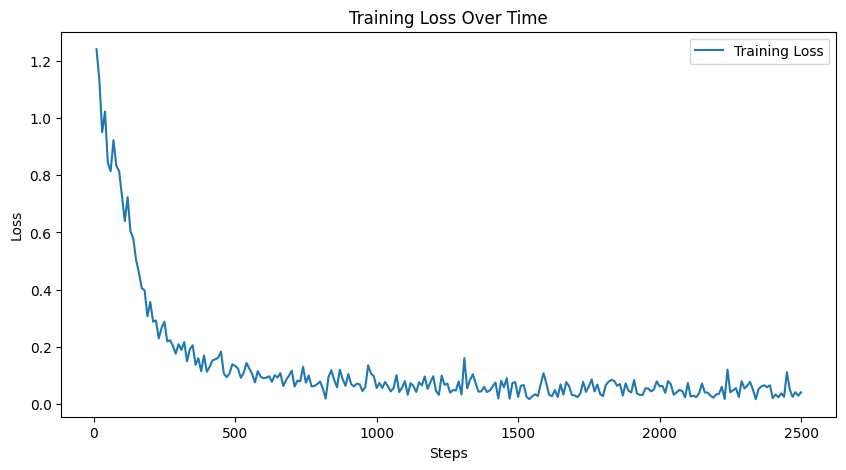

In [103]:
log_file = f"extracted_model/model_output3/checkpoint-2500/trainer_state.json"

# Read the log file
with open(log_file, 'r') as f:
    logs = json.load(f)

# Extract training loss values
steps = []
losses = []
for log in logs["log_history"]:
    if "loss" in log:
        steps.append(log["step"])
        losses.append(log["loss"])

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(steps, losses, label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend()
plt.show()

We want to compare scores:

In [104]:
# Function to make a prediction and get the logits
def predict_and_get_logits(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Perform the forward pass
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Extract the logits from the outputs
    logits = outputs.logits.squeeze().item()  # Assuming binary classification and batch size of 1
    
    return logits

def compare_texts(text1, text2):
    logit1 = predict_and_get_logits(text1)
    logit2 = predict_and_get_logits(text2)

    if logit1 > logit2:
        print("selected first")
        print(text1, f"score: {logit1}")

        return text1
    else:
        print("selected second")
        print(text2,  f"score: {logit2}")

        return text2

compare_texts(train_str['chosen'][2],train_str['rejected'][2])

selected first


Human: How do I know if this is a good investment.

Assistant: Answer: To determine if an investment is a good one, it is important to consider the potential risks and rewards of the investment, as well as the cost, expected rate of return, and timeline involved in the investment. Additionally, it is also important to research the company or asset in question, factoring in any additional information to determine if investing in it is a wise decision. score: 8.073410987854004


'\n\nHuman: How do I know if this is a good investment.\n\nAssistant: Answer: To determine if an investment is a good one, it is important to consider the potential risks and rewards of the investment, as well as the cost, expected rate of return, and timeline involved in the investment. Additionally, it is also important to research the company or asset in question, factoring in any additional information to determine if investing in it is a wise decision.'

In [105]:
# Define the number of samples to evaluate
N = 10

# Initialize a counter for correct selections
correct_selections = 0

# Iterate over the first N pairs of chosen and rejected responses
for chosen, rejected in zip(train_str['chosen'][0:N], train_str['rejected'][0:N]):
    # Print the chosen response for reference
    print("Chosen Response:\n", chosen)
    
    # Use the compare_texts function to determine which response is better
    selected_text = compare_texts(chosen, rejected)
    
    # Check if the selected text is the chosen response
    if selected_text == chosen:
        correct_selections += 1

# Calculate the accuracy as the ratio of correct selections to the total number of samples
accuracy = correct_selections / N

# Print the accuracy
print("Accuracy:", accuracy) 

Chosen Response:
 

Human: I was wondering if you could walk me through the process of setting up a hydroponic garden for herbs.

Assistant: Sure! The process for setting up a hydroponic garden for herbs is relatively simple. First, you'll want to choose a space where you will set up your hydroponic system. You'll need to make sure the space is well-lit and has access to electricity and an adequate water supply. Next, you'll need to choose the type of hydroponic system you want to use. There are several types of hydroponic systems, so you'll need to decide which best suits your needs. Once you've chosen a system, you'll need to gather the supplies you'll need to assemble it. This includes things like pumps, growing trays, grow lights, and nutrients. Once you've assembled the system, you'll need to add your choice of herbs to the system. Lastly, you'll need to monitor and adjust the system as needed to ensure your herbs are getting the correct amount of light, water, and nutrients.
sele

# 3) PPO: not done

# 4) DPO

## Models and tokenizer

In [106]:
# Load the GPT-2 model, to be fine-tuned using DPO
model = AutoModelForCausalLM.from_pretrained("gpt2")

# Load a reference model 
model_ref = AutoModelForCausalLM.from_pretrained("gpt2")

# Load the GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Set the pad token to the end-of-sequence token
tokenizer.pad_token = tokenizer.eos_token
# Set the padding side to "right" to fix the overflow issue with FP16 training
tokenizer.padding_side = "right"

# Disable the use of the cache during the model's forward pass
model.config.use_cache = False

## Dataset and data preparation

In [107]:
ds = load_dataset("BarraHome/ultrafeedback_binarized")

In [108]:
ds["train_prefs"][0].keys()

dict_keys(['prompt', 'prompt_id', 'chosen', 'rejected', 'messages', 'score_chosen', 'score_rejected'])

Now, put the data set in the format that the DPO trainer accepts, which is:

| Chosen | Rejected | Prompt |
| --- | --- | --- |
 | Developing a daily habit of drawing can be challenging <br>but with consistent practice, and a few tips. | One way to develop a habit of drawing daily is <br>to allocate a specific time interval for drawing. | How can I develop a habit of drawing daily?|

In [109]:
for key in ds:
    #cnt = round(ds[key].__len__()*0.05)
    cnt=50
    ds[key] = ds[key].select(range(cnt))

# Define a function to process the data
def process(row):
    # delete unwanted columns
    del row["prompt_id"]
    del row["messages"]
    del row["score_chosen"]
    del row["score_rejected"]
    # retrieve the actual response text
    row["chosen"] = row["chosen"][-1]["content"]
    row["rejected"] = row["rejected"][-1]["content"]

    return row

# Apply the data processing function to the dataset
ds = ds.map(
    process,
    num_proc=multiprocessing.cpu_count(),
    load_from_cache_file=False,
)

# Split the dataset into training and evaluation sets
train_dataset = ds['train_prefs']
eval_dataset = ds['test_prefs']

python(20213) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20214) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20215) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20216) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20217) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20218) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20219) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20220) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Map (num_proc=8):   0%|          | 0/50 [00:00<?, ? examples/s]

python(20221) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20222) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20223) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20224) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20225) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20226) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20227) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20228) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20229) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Map (num_proc=8):   0%|          | 0/50 [00:00<?, ? examples/s]

python(20230) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20231) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20232) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20233) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20234) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20235) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20236) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20237) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20238) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Map (num_proc=8):   0%|          | 0/50 [00:00<?, ? examples/s]

python(20239) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20240) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20241) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20242) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20243) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20244) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20245) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20246) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20247) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Map (num_proc=8):   0%|          | 0/50 [00:00<?, ? examples/s]

python(20248) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20249) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20250) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20251) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20252) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20253) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20254) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20255) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20256) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Map (num_proc=8):   0%|          | 0/50 [00:00<?, ? examples/s]

python(20257) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20258) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20259) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20260) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20261) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20262) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20263) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20264) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20265) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Map (num_proc=8):   0%|          | 0/50 [00:00<?, ? examples/s]

python(20266) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [110]:
train_dataset[0]

{'prompt': 'how can i develop a habit of drawing daily',
 'chosen': "Developing a daily habit of drawing can be challenging but with consistent practice and a few tips, it can become an enjoyable and rewarding part of your daily routine. Here are some strategies to help you develop the habit of drawing daily:\n\n1. Set a specific time: Allocate a specific time of the day to draw. It could be in the morning, afternoon, or evening. Make drawing a part of your daily routine.\n2. Set a specific duration: Determine the amount of time you want to spend on drawing each day. It can be as little as 10 minutes or as long as an hour. Be consistent with the duration to help build the habit.\n3. Start small and simple: Don't try to create a masterpiece every day, start with simple and easy-to-do sketches. Focus on improving your skills gradually.\n4. Use a variety of tools and mediums: Experiment with different tools like pencils, pens, markers, and different mediums like paper, canvas, or digital 

## DPO (with also LoRA)

In [111]:
lora_config = LoraConfig(
        # The rank of the low-rank adaptation weights
        r=4,
        # The target modules to apply the low-rank adaptation to
        target_modules=['c_proj','c_attn'],
        # The task type for the low-rank adaptation
        task_type="CAUSAL_LM",
        # The scaling factor for the low-rank adaptation weights
        lora_alpha=8,
        # The dropout probability for the low-rank adaptation weights
        lora_dropout=0.1,
        # The bias mode for the low-rank adaptation
        bias="none",
)

In [112]:
training_args = DPOConfig(
    # The beta parameter for the DPO loss function
    #beta is the temperature parameter for the DPO loss, typically something in the range of 0.1 to 0.5 . 
    beta=0.1,
    # The output directory for the training
    output_dir="dpo",
    # The number of training epochs
    num_train_epochs=5,
    # The batch size per device during training
    per_device_train_batch_size=1,
    # The batch size per device during evaluation
    per_device_eval_batch_size=1,
    # Whether to remove unused columns from the dataset
    remove_unused_columns=False,
    # The number of steps between logging training progress
    logging_steps=10,
    # The number of gradient accumulation steps
    gradient_accumulation_steps=1,
    # The learning rate for the optimization
    learning_rate=1e-4,
    # The evaluation strategy (e.g., after each step or epoch)
    evaluation_strategy="epoch",
    # The number of warmup steps for the learning rate scheduler
    warmup_steps=2,
    # Whether to use 16-bit (float16) precision
    fp16=False,
    bf16=False,
    # The number of steps between saving checkpoints
    save_steps=500,
    # The maximum number of checkpoints to keep
    #save_total_limit=2,
    # The reporting backend to use (set to 'none' to disable, you can also report to wandb or tensorboard)
    report_to='none'
)

In [113]:
tokenizer.pad_token = tokenizer.eos_token

# Create a DPO trainer
# This trainer will handle the fine-tuning of the model using the DPO technique
trainer = DPOTrainer(
        # The model to be fine-tuned
        model = model,
        tokenizer = tokenizer,
        # The reference model (not used in this case because LoRA has been used)
        ref_model=None,
        # The DPO training configuration
        args=training_args,
        # The beta parameter for the DPO loss function
       
        # The training dataset
        train_dataset=train_dataset,
        # The evaluation dataset
        eval_dataset=eval_dataset,
        # The tokenizer for the model
        #tokenizer=tokenizer,
        # The PEFT (Parallel Efficient Finetuning) configuration
        peft_config=lora_config,
        # The maximum prompt length
        #max_prompt_length=512,
        # The maximum sequence length
        #max_length=512,
    )

In [114]:
#trainer.train()

## Evaluate and generation

In [115]:
# Define the URL and the filename
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/YIDeT3qihEpWChdXN_RmTg/DPO-tar.gz'
filename = './DPO.tar'

# Download the file
response = requests.get(url)

# Save the file locally
with open(filename, 'wb') as f:
    f.write(response.content)

# Extract the tar file
if tarfile.is_tarfile(filename):
    with tarfile.open(filename, 'r') as tar:
        tar.extractall()
        print("Files extracted:", tar.getnames())
else:
    print("The adownloaded file is not a tar file.")

dpo_model = AutoModelForCausalLM.from_pretrained('./DPO')

Files extracted: ['DPO', 'DPO/adapter_config.json', 'DPO/tokenizer_config.json', 'DPO/merges.txt', 'DPO/adapter_model.safetensors', 'DPO/special_tokens_map.json', 'DPO/training_args.bin', 'DPO/README.md', 'DPO/vocab.json']


In [116]:
# Define the generation configuration for the DPO model
# This sets the parameters for text generation
generation_config = GenerationConfig(
        # Use sampling to generate diverse text
        do_sample=True,
        # Top-k sampling parameter
        top_k=1,
        # Temperature parameter to control the randomness of the generated text
        temperature=0.1,
        # Maximum number of new tokens to generate
        max_new_tokens=25,
        # Use the end-of-sequence token as the padding token
        pad_token_id=tokenizer.eos_token_id
    )

# Define the input prompt for text generation
PROMPT = "Is a higher octane gasoline better for your car?"
# Encode the prompt using the tokenizer
inputs = tokenizer(PROMPT, return_tensors='pt')

# Generate text using the DPO model
outputs = dpo_model.generate(**inputs, generation_config=generation_config)
# Decode the generated text and print it
print("DPO response:\t",tokenizer.decode(outputs[0], skip_special_tokens=True))

# Load the pre-trained GPT-2 model
gpt2_model = AutoModelForCausalLM.from_pretrained('gpt2')
# Generate text using the GPT-2 model
outputs = gpt2_model.generate(**inputs, generation_config=generation_config)
# Decode the generated text and print it
print("\nGPT2 response:\t",tokenizer.decode(outputs[0], skip_special_tokens=True))

DPO response:	 Is a higher octane gasoline better for your car?

The answer is yes. The higher octane gasoline is better for your car.

The higher octane gasoline

GPT2 response:	 Is a higher octane gasoline better for your car?

The answer is yes. The higher octane gasoline is more efficient and more fuel efficient.

The higher oct
